## Chapter 14. Mutimedia data
#### Notebook for R

Van Atteveldt, W., Trilling, D. & Arcila, C. (2022). <a href="https://cssbook.net" target="_blank">Computational Analysis of Communication</a>. Wiley.

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/ccs-amsterdam/ccsbook/blob/master/chapter14/chapter_14_r.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
</table>

In [ ]:
#Run these lines if working on Google Colab
#system("apt install libmagick++-dev", intern=TRUE) 

In [1]:
install.packages(c("magick", "glue","lsa",
    "tidyverse","dslabs","randomForest","caret",
    "tensorflow","keras"))

Warning message:
“package ‘randomForest’ is not available for this version of R

A version of this package for your version of R might be available elsewhere,
see the ideas at
https://cran.r-project.org/doc/manuals/r-patched/R-admin.html#Installing-packages”



The downloaded binary packages are in
	/var/folders/p2/lqdpfmcj23lc082b9kvv9sj80000gn/T//RtmppjOkHM/downloaded_packages


In [1]:
library(magick)
library(lsa)
library(tidyverse)
library(dslabs)
library(randomForest)
library(caret)
library(tensorflow)
library(keras)

Linking to ImageMagick 6.9.12.3
Enabled features: cairo, fontconfig, freetype, heic, lcms, pango, raw, rsvg, webp
Disabled features: fftw, ghostscript, x11

Loading required package: SnowballC

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.3     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

Warning message:
“package ‘readr’ was built under R version 4.0.5”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:dplyr’:

    combine


The following object is masked from ‘package:ggplot2’:

    margin


Warning message:
“package ‘caret’ was built under R version 4.0.5”
Loading required package: lattice


A

###  Storing, representing, and converting multimedia data

In [2]:
myimg1 = image_read(
    "https://cssbook.net/d/259_3_32_15.jpg")
myimg2 = image_read(
    "https://cssbook.net/d/298_5_52_15.png")
rbind(image_info(myimg1), image_info(myimg2))

format,width,height,colorspace,matte,filesize,density
<chr>,<int>,<int>,<chr>,<lgl>,<int>,<chr>
JPEG,805,453,sRGB,FALSE,75275,72x72
PNG,1540,978,sRGB,TRUE,2752059,57x57


In [3]:
myimg1_L = image_convert(myimg1,
                         colorspace = "gray")
print(class(myimg1_L))
myimg1_L_array = as.integer(myimg1_L[[1]])
print(class(myimg1_L_array))
print(dim(myimg1_L_array))


[1] "magick-image"
[1] "array"
[1] 453 805   1


In [4]:
myimg1_RGB = image_convert(myimg1,
                           colorspace = "RGB")
print(class(myimg1_RGB))
myimg1_RGB_array = as.integer(myimg1_RGB[[1]])
print(class(myimg1_RGB_array))
print(dim(myimg1_RGB_array))


[1] "magick-image"
[1] "array"
[1] 453 805   3


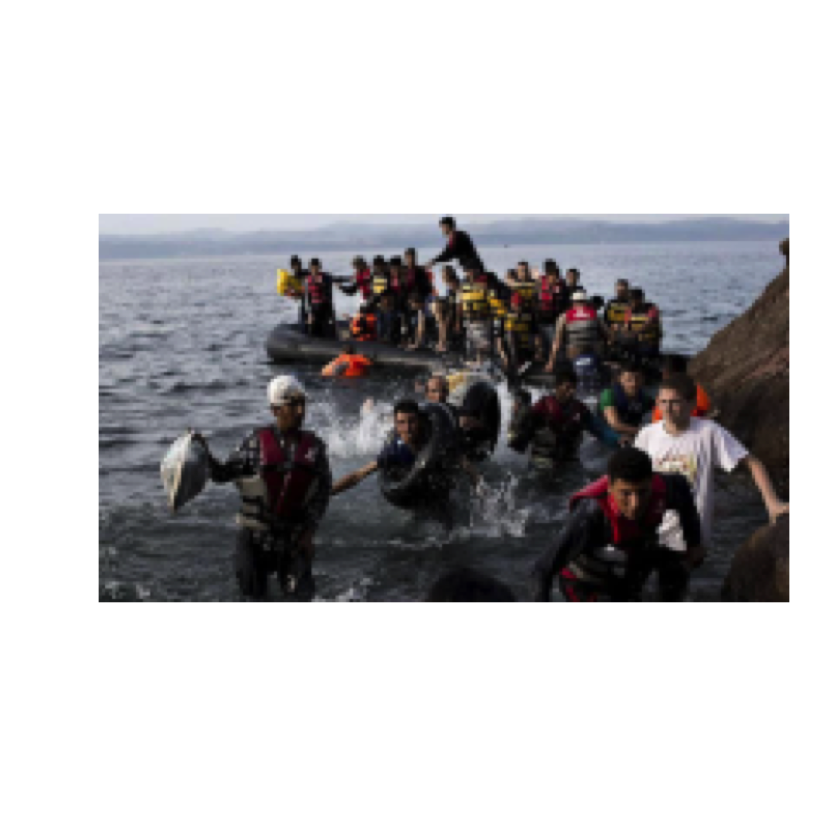

In [5]:
#Resize and visalize myimg1. Reduce to 25%
myimg1_RGB_25 = image_scale(myimg1_RGB,
        image_info(myimg1_RGB)["width"][[1]]*0.25)
plot(myimg1_RGB_25)

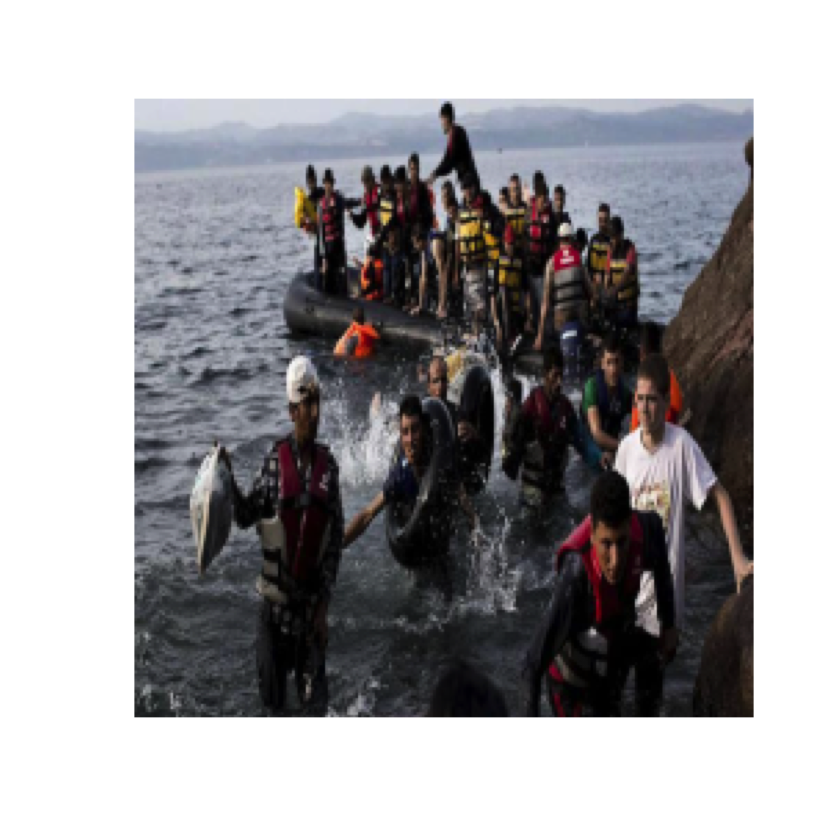

In [6]:
#Resize and visalize myimg1. Resize to 224 x 224
#! indicates to resize width and height exactly
myimg1_RGB_224 = image_scale(myimg1_RGB,
                             "!224x!224")
plot(myimg1_RGB_224)

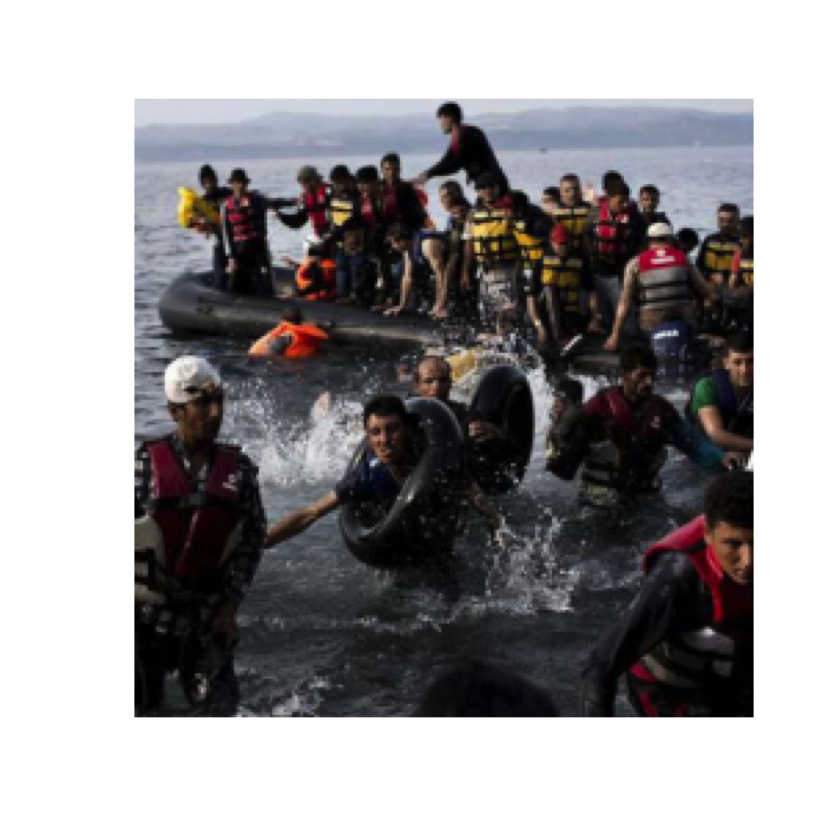

In [7]:
#Crop and resize to 224 x 224
#Create function
crop = function(img) {
    width = image_info(img)["width"][[1]]
    height = image_info(img)["height"][[1]]
    if (width > height) {
        return (image_crop(img, 
                sprintf("%dx%d+%d", height,
                    height, (width-height)/2)))
    }   else  {
        return (image_crop(img,
                sprintf("%sx%s+%s+%s", width,
        width, (width-width), (height-width)/2)))
        }
    }

myimg1_RGB_crop = crop(myimg1_RGB)
myimg1_RGB_crop_224 = image_scale(myimg1_RGB_crop,
                                  "!224x!224")
plot(myimg1_RGB_crop_224)

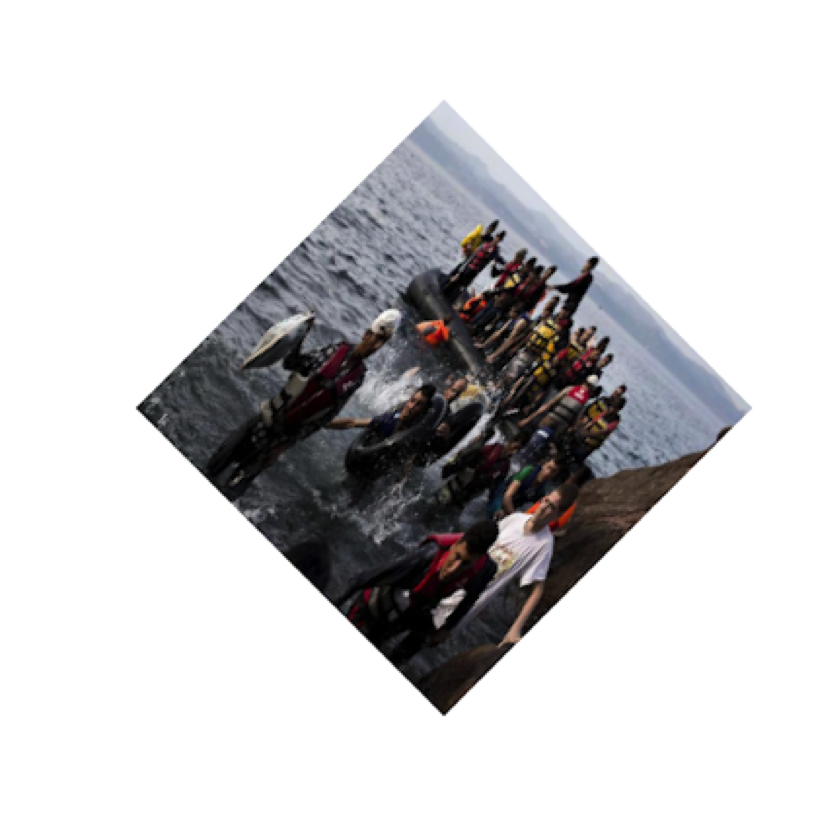

In [8]:
#Rotate 45 degrees
myimg1_RGB_224_rot = image_rotate(
    myimg1_RGB_224, 45)
plot(myimg1_RGB_224_rot)

In [9]:
#Create two 15x15 small images to compare

#image1
myimg1_RGB_crop_15 = image_scale(
    myimg1_RGB_crop_224, 15)
img_vect1 = as.integer(myimg1_RGB_crop_15[[1]])
img_vect1 = as.vector(img_vect1)

#image2
myimg2_RGB = image_convert(myimg2,
                           colorspace = "RGB")
myimg2_RGB_crop = crop(myimg2_RGB)
myimg2_RGB_crop_15 = image_scale(
    myimg2_RGB_crop, 15)
img_vect2 = as.integer(myimg2_RGB_crop_15[[1]])
#drop the extra channel for comparision
img_vect2 = img_vect2[,,-4] 
img_vect2 = as.vector(img_vect2)

matrix = cbind(img_vect1, img_vect2)

cosine(img_vect1, img_vect2)
cosine(matrix)

0.8994653


,img_vect1,img_vect2
img_vect1,1.0000000,0.8994653
img_vect2,0.8994653,1.0000000


### Image classification

####  Basic classification with shallow algorithms

In [10]:
mnist = read_mnist()

X_train = mnist$train$images
y_train = factor(mnist$train$labels)
X_test = mnist$test$images
y_test = factor(mnist$test$labels)

print("Shape = ")
dim(mnist$train$images)
print("Numbers in training set = ")
print(factor(y_train[1:10]), max.levels = 0)
print("Numbers in test set = ")
print(factor(y_test[1:10]), max.levels = 0)

[1] "Shape = "


[1] 60000   784

[1] "Numbers in training set = "
 [1] 5 0 4 1 9 2 1 3 1 4
[1] "Numbers in test set = "
 [1] 7 2 1 0 4 1 4 9 5 9


In [12]:
#Multiclass classification with RandomForest
rf_clf = randomForest(X_train, y_train, ntree=100)
rf_clf
predict(rf_clf, X_test[1:10,])
predictions = predict(rf_clf, X_test)
cm = confusionMatrix(predictions, y_test)
print(cm$overall["Accuracy"])


Call:
 randomForest(x = X_train, y = y_train, ntree = 100) 
               Type of random forest: classification
                     Number of trees: 100
No. of variables tried at each split: 28

        OOB estimate of  error rate: 3.41%
Confusion matrix:
     0    1    2    3    4    5    6    7    8    9 class.error
0 5849    2    8    2    4    5   20    1   28    4  0.01249367
1    0 6643   34   10   10    9    5   13   11    7  0.01468407
2   27    8 5762   28   30    0   22   39   37    5  0.03289695
3    7    9   74 5810    3   79   10   53   58   28  0.05235687
4    9    8   10    0 5647    2   24   12   16  114  0.03337898
5   18    8   13   55   16 5190   46    7   43   25  0.04261206
6   26   10    5    0    8   37 5814    0   18    0  0.01757350
7    3   23   54    6   37    0    0 6050   10   82  0.03431764
8   13   35   30   48   28   46   29    5 5563   54  0.04922236
9   22    9   12   64   87   21    4   52   50 5628  0.05395865

1  2  3  4  5  6  7  8  9 10 
 7  2  1  0  4  1  4  9  5  9 
Levels: 0 1 2 3 4 5 6 7 8 9

Accuracy 
   0.971 


#### Deep Learning for Image Analysis

In [11]:
fashion_mnist <- dataset_fashion_mnist()
c(X_train, y_train) %<-% fashion_mnist$train
c(X_test, y_test) %<-% fashion_mnist$test
class_names = c("T-shirt/top","Trouser",
    "Pullover","Dress", "Coat", "Sandal","Shirt",
    "Sneaker", "Bag","Ankle boot")
X_train <- X_train / 255
y_test <- y_test / 255
print(dim(X_train))
print(dim(X_test))

Loaded Tensorflow version 2.8.0



[1] 60000    28    28
[1] 10000    28    28


In [12]:
model = keras_model_sequential()
model %>%
  layer_flatten(input_shape = c(28, 28)) %>%
  layer_dense(units=300, activation="relu") %>%
  layer_dense(units=100, activation="relu") %>%
  layer_dense(units=10, activation="softmax")
model

Model: "sequential"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 flatten (Flatten)                  (None, 784)                     0           
                                                                                
 dense_2 (Dense)                    (None, 300)                     235500      
                                                                                
 dense_1 (Dense)                    (None, 100)                     30100       
                                                                                
 dense (Dense)                      (None, 10)                      1010        
                                                                                
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
________________________________________________________________________________

In [13]:
model %>% compile(
  optimizer = "sgd", 
  loss = "sparse_categorical_crossentropy",
  metrics = c("accuracy")
)
history = model %>% fit(X_train, y_train,
    validation_split=0.1, epochs=5, verbose= 2)
print(history$metrics)
score = model %>% evaluate(
    X_test, y_test, verbose = 0)
print("Evaluation")
print(score)

$loss
[1] 0.7321857 0.4862316 0.4412138 0.4125885 0.3933831

$accuracy
[1] 0.7612222 0.8325926 0.8458518 0.8564815 0.8623889

$val_loss
[1] 0.5111727 0.4504242 0.4330572 0.4080020 0.3937299

$val_accuracy
[1] 0.8268333 0.8458334 0.8490000 0.8506666 0.8596666

[1] "Evaluation"
     loss  accuracy 
1855.0688    0.0811 


In [14]:
img = X_test[1:6, , , drop = FALSE]
class_pred = model %>% predict(img) %>% k_argmax()
class_pred

tf.Tensor([9 2 1 1 6 1], shape=(6,), dtype=int64)

### Deep Learning for Image Analysis

In [43]:
fashion_mnist <- dataset_fashion_mnist()
c(X_train, y_train) %<-% fashion_mnist$train
c(X_test, y_test) %<-% fashion_mnist$test
class_names = c("T-shirt/top","Trouser",
    "Pullover","Dress", "Coat", "Sandal","Shirt",
    "Sneaker", "Bag","Ankle boot")
X_train <- X_train / 255
y_test <- y_test / 255
print(dim(X_train))
print(dim(X_test))

[1] 60000    28    28
[1] 10000    28    28


In [44]:
model = keras_model_sequential()
model %>%
layer_flatten(input_shape = c(28, 28)) %>%
layer_dense(units=300, activation="relu") %>%
layer_dense(units=100, activation="relu") %>%
layer_dense(units=10, activation="softmax")
model

Model
Model: "sequential_4"
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
flatten_4 (Flatten)                 (None, 784)                     0           
________________________________________________________________________________
dense_14 (Dense)                    (None, 300)                     235500      
________________________________________________________________________________
dense_13 (Dense)                    (None, 100)                     30100       
________________________________________________________________________________
dense_12 (Dense)                    (None, 10)                      1010        
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
________________________________________________________________________________



#### Fine tuning an open source  CNN

In [15]:
model_resnet50 = application_resnet50(
    weights="imagenet")
#model_resnet50

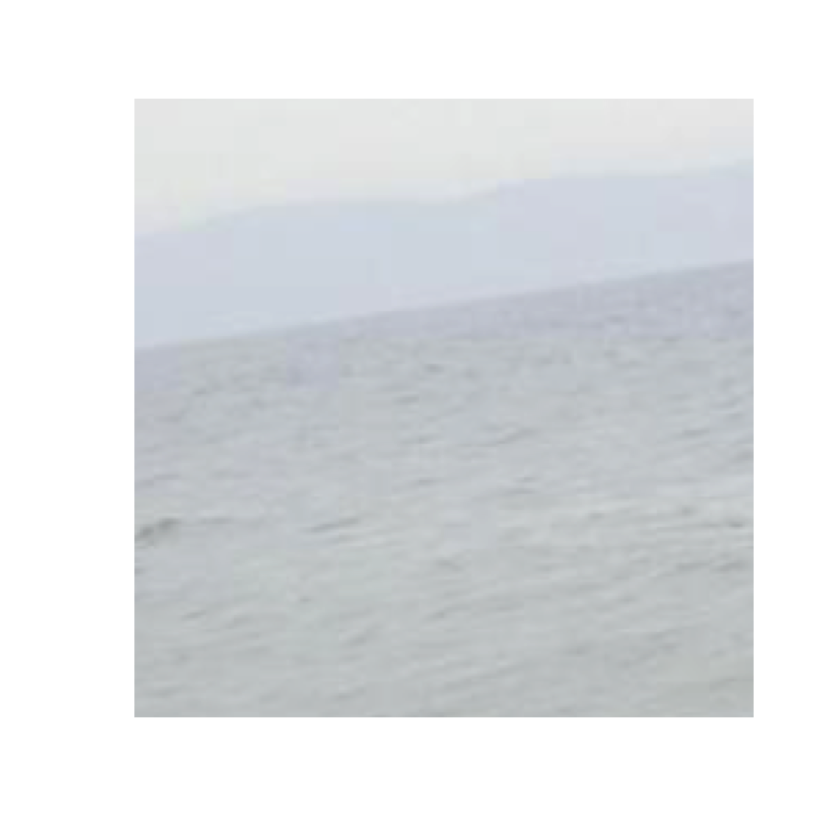

In [16]:
picture1 = image_crop(myimg2_RGB, "224x224+50+50")
plot(picture1)
picture1 = as.integer(picture1[[1]])
#drop the extra channel for comparision
picture1 = picture1[,,-4] 
picture1 = array_reshape(picture1, 
                         c(1, dim(picture1)))
picture1 = imagenet_preprocess_input(picture1)

In [17]:
preds1 = model_resnet50 %>% predict(picture1)
imagenet_decode_predictions(preds1, top = 3)[[1]]

class_name,class_description,score
<chr>,<chr>,<dbl>
n09421951,sandbar,0.07926150
n04347754,submarine,0.04810239
n02066245,grey_whale,0.04798750


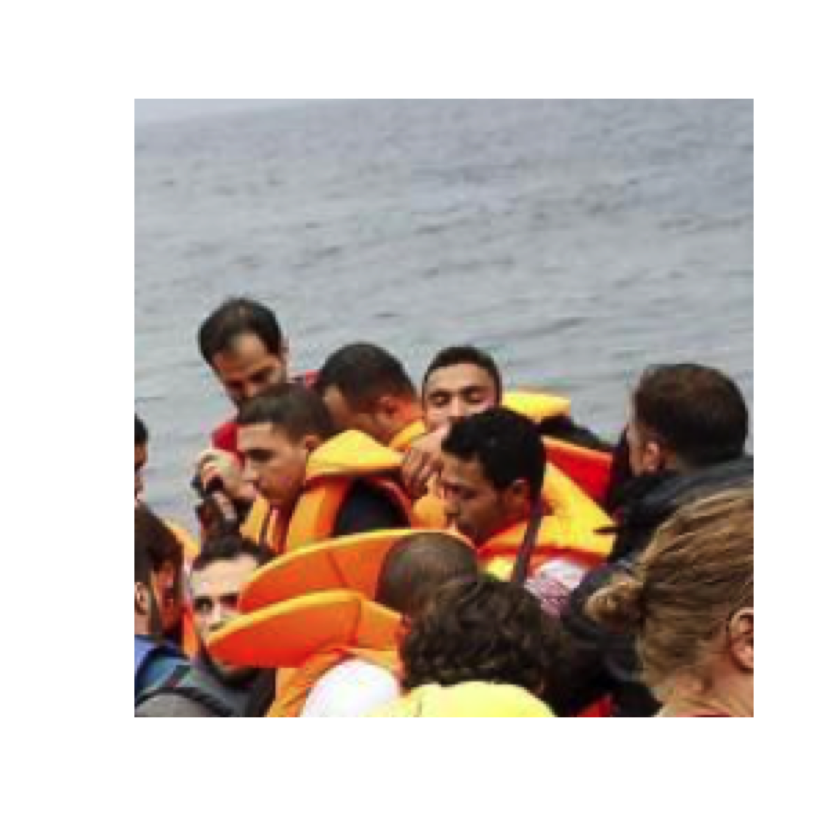

In [18]:
picture2 = image_crop(myimg2_RGB, "224x224+1000")
plot(picture2)
picture2 = as.integer(picture2[[1]])
#drop the extra channel for comparision
picture2 = picture2[,,-4] 
picture2 = array_reshape(picture2,
                         c(1, dim(picture2)))
picture2 = imagenet_preprocess_input(picture2)

In [19]:
preds2 = model_resnet50 %>% predict(picture2)
imagenet_decode_predictions(preds2, top = 3)[[1]]

class_name,class_description,score
<chr>,<chr>,<dbl>
n03662601,lifeboat,0.39761329
n04273569,speedboat,0.11085816
n02704792,amphibian,0.06916215
